<a href="https://colab.research.google.com/github/DanieleCecca/Automatic-speech-recognition/blob/main/Automatic_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASR Automatic speech recognition

*Daniele Cecca*

*Matr. 914358*

*MSc Artificial Intelligence for Science and Technology*

*Email: d.cecca@campus.unimib.it*

This work presents an Automatic Speech Recognition (ASR) system built with PyTorch and torchaudio. Audio data is preprocessed, tokenized with SentencePiece, and transformed into features for training. A deep learning model is implemented, trained, and evaluated using Word Error Rate (WER). The notebook demonstrates the end-to-end pipeline of ASR, from raw audio to transcription, with visualizations and performance analysis.

## Imports and environment setup

In [ ]:
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import soundfile as sf
import re
import sentencepiece as spm
import torchaudio
from IPython.display import display, Audio
import torch.nn.functional as F
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from jiwer import wer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

## Constants

In [ ]:
DATA_PATH_CSV='/content/drive/MyDrive/Prosail_project/cv-corpus-12.0-delta-2022-12-07/it/validated.tsv'

In [ ]:
DATA_PATH_AUDIO='/content/drive/MyDrive/Prosail_project/cv-corpus-12.0-delta-2022-12-07/it/clips'

## Functions

### Data functions

In [ ]:
def get_info_audio(audio_path):
  audio, sr = librosa.load(audio_path, sr=None)
  info = sf.info(audio_path)
  print(info)
  return audio,sr

In [ ]:
def show_waveform(audio, sr=None):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(audio, sr=sr)

In [ ]:
def show_spectrogram(audio, sr=None):
  S = librosa.stft(audio)
  S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
  plt.colorbar(format="%+2.0f dB")

In [ ]:
def show_static_spectrogram(audio, sr=None):
  fft = np.fft.fft(audio)
  magnitude = np.abs(fft)[:len(fft)//2]  # Solo parte positiva
  freqs = np.linspace(0, sr/2, len(magnitude))

  plt.figure(figsize=(10, 4))
  plt.plot(freqs, magnitude)
  plt.title("Spettro in frequenza")
  plt.xlabel("Frequenza (Hz)")
  plt.ylabel("Ampiezza")
  plt.show()

In [ ]:
def show_logmel(audio, sr):
    mels = librosa.feature.melspectrogram(
        y=audio, sr=sr,
        n_fft=400, hop_length=160, win_length=400,
        n_mels=80, fmin=20, fmax=7600, power=2.0
    )

    logmels = librosa.power_to_db(mels, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(
        logmels, x_axis="time", y_axis="mel", sr=sr, fmin=20, fmax=7600
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Mel Spectrogram")
    plt.tight_layout()
    plt.show()

In [ ]:
def sampling_and_quantization(audio_path,output_folder):
  # Carica in 16 kHz mono
  audio, sr = librosa.load(audio_path, sr=16000, mono=True)

  os.makedirs(output_folder, exist_ok=True)

  # Nuovo nome file con estensione .wav
  filename = os.path.splitext(os.path.basename(audio_path))[0] + ".wav"
  output_path = os.path.join(output_folder, filename)

  sf.write(output_path, audio, 16000, subtype='PCM_16')

In [ ]:
def normalize_mel(x):
    mu = np.mean(x, axis=1, keepdims=True)
    sigma = np.std(x, axis=1, keepdims=True) + 1e-8
    return (x - mu) / sigma

In [ ]:
def extract_mel_features(df):
    X = []
    y = []

    for audio_path, sentence in zip(df['path'], df['sentence']):
        audio, sr = librosa.load(audio_path, sr=16000, mono=True)

        # Estrai mel-spectrogram
        mels = librosa.feature.melspectrogram(
            y=audio, sr=16000, n_fft=400, hop_length=160, win_length=400,
            n_mels=80, fmin=20, fmax=7600, power=2.0
        )

        # Converti in log-Mel
        logmels = librosa.power_to_db(mels, ref=np.max)

        # Normalizza
        logmels_norm = normalize_mel(logmels)

        X.append(logmels_norm)
        y.append(sentence)

    return X, y

In [ ]:
def normalize_text(text):
    # minuscole e rimozione caratteri indesiderati
    text = text.lower().strip()
    text = re.sub(r"[^\w\sàèéìòóù]", " ", text)  # tieni lettere, numeri e spazi
    text = re.sub(r"\s+", " ", text)  # rimuovi spazi doppi
    return text

In [ ]:
def encode_ctc(text,sp):
    ids = sp.encode(normalize_text(text), out_type=int)
    return [i+1 for i in ids]  # shift di +1, lasciando 0 per blank

In [ ]:
def decode_ctc(ids,sp):
    # rimuovi blank e poi inverti lo shift
    ids = [i-1 for i in ids if i != BLANK_ID]
    return sp.decode(ids)

### Model functions

In [ ]:
def split_dataset(df: pd.DataFrame, val_ratio=0.1, test_ratio=0.1, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(df)); rng.shuffle(idx)
    n = len(idx); n_test = int(n*test_ratio); n_val = int(n*val_ratio)
    test_df = df.iloc[idx[:n_test]].reset_index(drop=True)
    val_df  = df.iloc[idx[n_test:n_test+n_val]].reset_index(drop=True)
    train_df= df.iloc[idx[n_test+n_val:]].reset_index(drop=True)

    return train_df, val_df, test_df

In [ ]:
def collate_ctc(batch, pad_value=0.0):
# trovo T max nel batch
    B = len(batch)
    n_mels = batch[0][0].shape[0]
    lengths = [m.shape[1] for m,_ in batch]
    T_max = max(lengths)

#Initialize a padded tensor of size (B, 80, Tmax) filled with zeros
    mels = torch.full((B, n_mels, T_max), pad_value, dtype=torch.float32)
    input_lengths = torch.tensor(lengths, dtype=torch.int64)

#per ogni elem in batch copio la parte nel padded tensor e lascio padding
    tgt_list, tgt_lens = [], []
    for i, (mel, ids) in enumerate(batch):
        T = mel.shape[1]
        mels[i, :, :T] = torch.from_numpy(mel)
        tgt = torch.from_numpy(ids)
        tgt_list.append(tgt)
        tgt_lens.append(len(ids))
#concateto tutte le sequenze target in un tensore
    targets_concat = torch.cat(tgt_list) if tgt_list else torch.empty(0, dtype=torch.int64)
    target_lengths = torch.tensor(tgt_lens, dtype=torch.int64)
    return mels, input_lengths, targets_concat, target_lengths

In [ ]:
def train_one_epoch(model, loader, optimizer, device=None, blank_id=0):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.train()

    total_loss, n_batches = 0.0, 0

    for mels, in_lens, y, y_lens in loader:
        mels = mels.to(device)
        in_lens = in_lens.to(device)
        y = y.to(device)
        y_lens = y_lens.to(device)

        optimizer.zero_grad()
        logits, out_lens = model(mels, in_lens)     # logits: (T',B,V)
        log_probs = F.log_softmax(logits, dim=-1)

        loss = F.ctc_loss(
            log_probs, y,
            input_lengths=out_lens,
            target_lengths=y_lens,
            blank=blank_id,
            zero_infinity=True,
            reduction="mean"
        )

        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        n_batches += 1

    return total_loss / max(1, n_batches)

In [ ]:
@torch.no_grad()
def validate_one_epoch(model, loader, device=None, blank_id=0):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    total_loss, n_batches = 0.0, 0

    for mels, in_lens, y, y_lens in loader:
        mels = mels.to(device)
        in_lens = in_lens.to(device)
        y = y.to(device)
        y_lens = y_lens.to(device)

        logits, out_lens = model(mels, in_lens)
        log_probs = F.log_softmax(logits, dim=-1)

        loss = F.ctc_loss(
            log_probs, y,
            input_lengths=out_lens,
            target_lengths=y_lens,
            blank=blank_id,
            zero_infinity=True,
            reduction="mean"
        )

        total_loss += float(loss.item())
        n_batches += 1

    return total_loss / max(1, n_batches)

In [ ]:
def greedy_decode(logits, blank_id=0):
    """
    logits: (T, B, V) V è il vocabolario - lista di liste di ID (senza blank e ripetizioni)
    """
    paths = logits.argmax(dim=-1).transpose(0, 1)  # (B, T)
    hyps = []
    for seq in paths.tolist():
        out, prev = [], None
        for t in seq:
            if t != blank_id and t != prev:#ripetiamo quello che viebe fatto il ctc loss solo che ctc usa beam search
                out.append(t)
            prev = t
        hyps.append(out)
    return hyps

In [ ]:
@torch.no_grad()
def test_wer(model, loader, decode_fn,sp, normalize_text_fn=None, device=None, blank_id=0):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    all_refs, all_hyps = [], []

    for mels, in_lens, y, y_lens in loader:
        mels = mels.to(device)
        in_lens = in_lens.to(device)
        y = y.to(device)
        y_lens = y_lens.to(device)

        # Forward
        logits, out_lens = model(mels, in_lens)  # logits: (T', B, V)

        # Hypotesi: greedy decode -> id list -> testo
        hyp_ids_batch = greedy_decode(logits, blank_id=blank_id)
        hyps = [decode_fn(ids,sp) for ids in hyp_ids_batch]

        # split dei target concatenati in base a tgt_lens
        refs_ids_batch = torch.split(y, y_lens.tolist())             # tuple di tensori 1D
        refs = [decode_fn(t.cpu().tolist(), sp) for t in refs_ids_batch]

        # Normalizzo come nel training e uso la stessa funzione
        if normalize_text_fn is not None:
            hyps = [normalize_text_fn(s) for s in hyps]
            refs = [normalize_text_fn(s) for s in refs]

        all_hyps.extend(hyps)
        all_refs.extend(refs)

    return all_refs, all_hyps

## Data

I use as dataset *cv-corpus-12.0-delta-2022-12-07*  which is provided by Mozilla Foundation

### Data exploration

Firt of all I explore the dataset, that i composed of 7952 audio track with thei associated transcription.
There are also other features like age, accents,... but this task we need the track audio its transciption

In [ ]:
df=pd.read_csv(DATA_PATH_CSV,sep='\t')
df['path']=DATA_PATH_AUDIO+'/'+df['path']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7952 entries, 0 to 7951
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   7952 non-null   object 
 1   path        7952 non-null   object 
 2   sentence    7952 non-null   object 
 3   up_votes    7952 non-null   int64  
 4   down_votes  7952 non-null   int64  
 5   age         6865 non-null   object 
 6   gender      6880 non-null   object 
 7   accents     248 non-null    object 
 8   locale      7952 non-null   object 
 9   segment     0 non-null      float64
dtypes: float64(1), int64(2), object(7)
memory usage: 621.4+ KB


I analyze one sample

In [ ]:
audio_path=df.sample(5,axis=0)['path'].iloc[0]
audio,sr=get_info_audio(audio_path)

/content/drive/MyDrive/Prosail_project/cv-corpus-12.0-delta-2022-12-07/it/clips_16k/common_voice_it_35774567.wav
samplerate: 16000 Hz
channels: 1
duration: 4.896 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]


In [ ]:
display(Audio(audio, rate=sr))

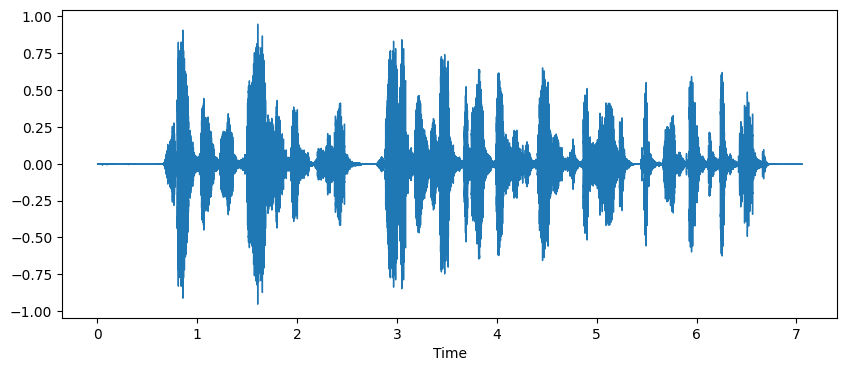

In [ ]:
show_waveform(audio,sr)

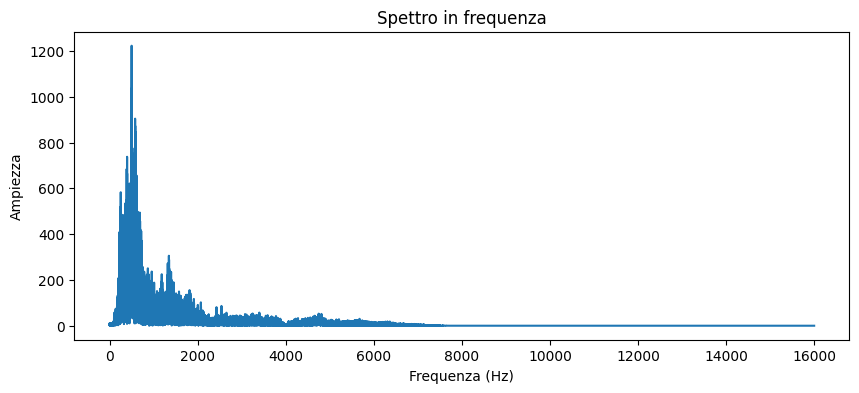

In [ ]:
show_static_spectrogram(audio,sr)

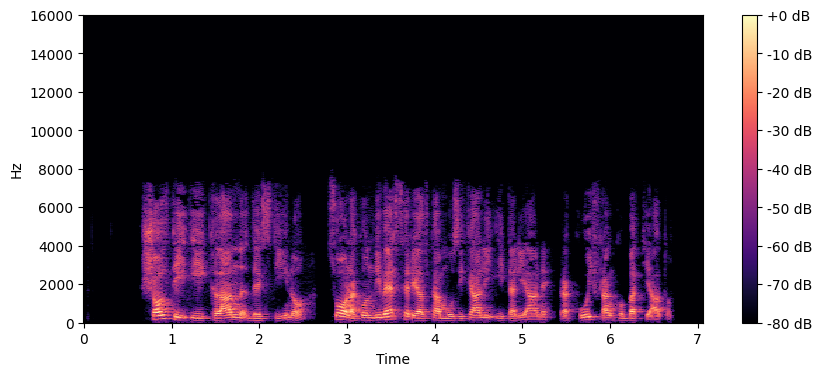

In [ ]:
show_spectrogram(audio,sr)

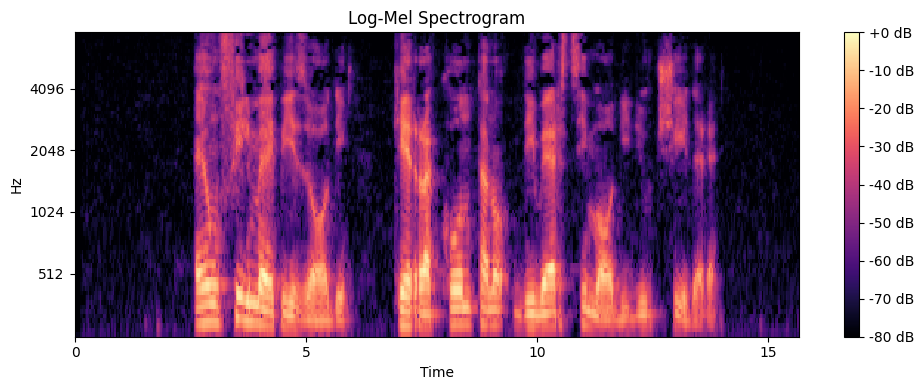

In [ ]:
show_logmel(audio,sr)

## Sampling and Quantization

As first step i sample end quantized the audio file(standardize).
I Loads the audio at 16 kHz, mono, this ensures every file has the same sample rate and number of channels. Most ASR models are trained on 16 kHz speech, which is enough to capture the important frequencies of human voice.

Saves it as WAV with PCM 16-bit encoding, unlike MP3 (which is compressed and lossy), WAV/PCM-16 is a clean, lossless format and is the standard input format for speech recognition pipelines.

This way, all the audio clips in the dataset have a uniform format, which avoids problems later on when extracting features or feeding them to the ASR model.

In [ ]:
for audio_path in df['path']:
  sampling_and_quantization(audio_path,output_folder=DATA_PATH_AUDIO+'_16k')

In [ ]:
new_path=[DATA_PATH_AUDIO+'_16k/'+ path for path in os.listdir(DATA_PATH_AUDIO+'_16k')]
df['path']=new_path

## Windowing - Mel Features extraction

In this step, I’m extracting the mel-spectrogram features from the dataset and pairing them with their corresponding text transcriptions.

The mel scale is a way of representing sound that is closer to how humans actually perceive pitch.

The human ear is more sensitive to differences in lower frequencies (e.g. 300 Hz vs 400 Hz) than in higher frequencies (e.g. 8000 Hz vs 8100 Hz).

The mel scale compresses high frequencies and expands low frequencies so that the spacing reflects human hearing rather than the raw linear scale of Hertz (Hz).

In [ ]:
X, y = extract_mel_features(df)

print(len(X), "campioni")
print(len(y), "trascrizioni")
print("Shape primo esempio:", X[0].shape)
print("Max T:", max([x.shape[1] for x in X]))
print("Min T:", min([x.shape[1] for x in X]))
print("Mean T", np.mean([x.shape[1] for x in X]))

7952 campioni
7952 trascrizioni
Shape primo esempio: (80, 469)
Max T: 1059
Min T: 130
Mean T 539.6995724346076


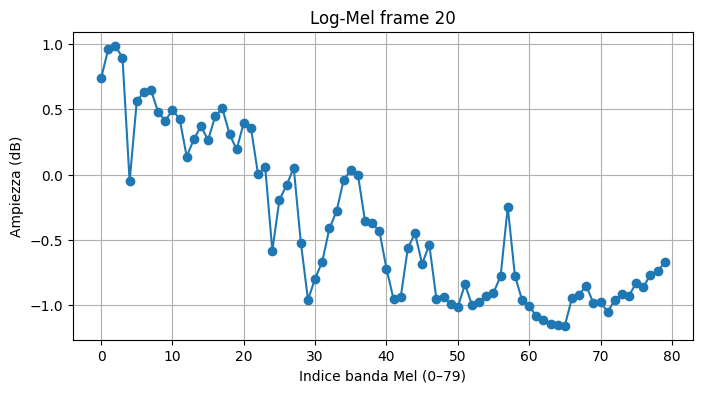

In [ ]:
mel_matrix = X[0]

frame_idx = 20
single_frame = mel_matrix[:, frame_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(single_frame)), single_frame, marker="o")
plt.title(f"Log-Mel frame {frame_idx}")
plt.xlabel("Indice banda Mel (0–79)")
plt.ylabel("Ampiezza (dB)")
plt.grid(True)
plt.show()

## Pre-processing : Normalization - Tokenization

I normalize the text

In [ ]:
y_norm=[normalize_text(text) for text in y]
print(y[0])
print(y_norm[0])

Leo Wilden
leo wilden


Now I tokenize the text by using Sentence Piece Tokenization, in particular the unigram version which use a top dow approach to create the vocabulary.

In [ ]:
with open('corpus.txt', 'w') as f:
    f.write("\n".join(t for t in y_norm if t.strip()))

spm.SentencePieceTrainer.Train(
    input='/content/corpus.txt',
    model_prefix="sp_it",
    vocab_size=1000,
    model_type="unigram",
    character_coverage=1.0,        # 1.0 per lingue latine
    shuffle_input_sentence=True,
    normalization_rule_name="nfkc",
    add_dummy_prefix=True,         # abilita il token di spazio "▁"
    remove_extra_whitespaces=True,
    hard_vocab_limit=False      # non fallisce se i pezzi unici sono meno di vocab_size
)

In [ ]:
sp = spm.SentencePieceProcessor(model_file="sp_it.model")

BLANK_ID = 0
VOCAB_SIZE = sp.get_piece_size() + 1  # +1 per blank

print("Vocab size:", VOCAB_SIZE)
print("Esempio:" ,encode_ctc(y[0],sp))
print("Decode:",decode_ctc(encode_ctc(y[0],sp),sp))

Vocab size: 1001
Esempio: [46, 5, 243, 7, 37, 62, 10]
Decode: leo wilden


## Class Dataset

I create the class dataset which is useful to prepare the data that will fed into the network.
As input features will take the mel features, while as target will take the sentence that will encode iside the constructor.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, sp):
        self.X = X
        self.y = [encode_ctc(t,sp) for t in y]
        self.sp = sp

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index].astype(np.float32), np.asarray(self.y[index], dtype=np.int64)



In [ ]:
dataset=Dataset(X,y_norm,sp)
x,y=dataset.__getitem__(0)
print(x.shape)
print(y)

(80, 253)
[ 46   5 243   7  37  62  10]


## Split of the data and dataloader

I divide the dataset in train test and validation set.


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_norm, test_size=0.20, random_state=42
)
# train e val
X_train, X_val, y_train, y_val = train_test_split(
    X, y_norm, test_size=0.10, random_state=42)

print(f"training:{len(X_train)}\nvale:{len(X_val)}\ntest:{len(X_test)}")

training:7156
vale:796
test:1591


In [ ]:
train_set = Dataset(X_train, y_train,sp)
val_set   = Dataset(X_val,   y_val,sp)
test_set  = Dataset(X_test,  y_test,sp)

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  collate_fn=collate_ctc, num_workers=2)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, collate_fn=collate_ctc, num_workers=2)
test_loader  = DataLoader(test_set,  batch_size=1, shuffle=False, collate_fn=collate_ctc, num_workers=2)

# Sanity check
x, x_len, y, y_len = next(iter(train_loader))
print(x.shape, x_len.shape, y.shape, y_len.shape)

torch.Size([8, 80, 839]) torch.Size([8]) torch.Size([193]) torch.Size([8])


## Model

I create the network for performing ASR.
The model is a simple network which is composed of 3 main building blocks:
- Prenet(Feature computation): normalizes and projects mel features into a hidden space.

- BiLSTM(Encoder): bidirectional LSTM that captures temporal context in both directions.

- Classifier: maps outputs to vocabulary logits.

In [ ]:
class BiLSTMCTC(nn.Module):
    def __init__(self, n_mels=80, hidden=256, n_layers=3, vocab_size=VOCAB_SIZE, dropout=0.1):
        super().__init__()
        self.prenet = nn.Sequential(
            nn.LayerNorm(n_mels),
            nn.Linear(n_mels, hidden),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden * 2, vocab_size)  # *2 per biLSTM

    def forward(self, x, lengths):

        # (B, 80, T) -> (B, T, 80)
        x = x.transpose(1, 2)
        x = self.prenet(x)  # (B, T, H)

        # pack per ignorare padding nell’LSTM
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)  # (B, T_max, 2H)

        out = self.dropout(out)
        out = self.classifier(out)                 # (B, T_max, V)
        out = out.transpose(0, 1)                  # (T_max, B, V)
        return out, lengths


In [ ]:
model=BiLSTMCTC()
model

BiLSTMCTC(
  (prenet): Sequential(
    (0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=80, out_features=256, bias=True)
    (2): ReLU()
  )
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=512, out_features=1001, bias=True)
)

### Train

I train the model and I save the one with the smallest val loss.
In this I avoid to save an overfitted model.

As loss I use CTC (Connectionist Temporal Classification) is a loss function designed for sequence tasks like speech recognition, where the input (audio frames) and output (text) have different lengths and no exact alignment. CTC allows the model to learn by considering all possible alignments between the audio and transcription, using special “blank” tokens to handle variable timing


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
best_val_loss = float('inf')  # inizialmente infinito
train_losses = []
val_losses = []

for epoch in range(1, 50):
    tr = train_one_epoch(model, train_loader, optimizer, blank_id=0)
    va = validate_one_epoch(model, val_loader, blank_id=0)

    train_losses.append(tr)
    val_losses.append(va)
    print(f"[{epoch:02d}] train {tr:.4f} | val {va:.4f}")

    # Salva il modello se migliora
    if va < best_val_loss:
        best_val_loss = va
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best model saved at epoch {epoch} (val_loss={va:.4f})")


[01] train 6.8112 | val 5.9944
New best model saved at epoch 1 (val_loss=5.9944)
[02] train 5.9618 | val 5.8982
New best model saved at epoch 2 (val_loss=5.8982)
[03] train 5.9020 | val 5.8726
New best model saved at epoch 3 (val_loss=5.8726)
[04] train 5.8723 | val 5.8564
New best model saved at epoch 4 (val_loss=5.8564)
[05] train 5.8469 | val 5.8513
New best model saved at epoch 5 (val_loss=5.8513)
[06] train 5.8054 | val 5.8080
New best model saved at epoch 6 (val_loss=5.8080)
[07] train 5.7766 | val 5.7916
New best model saved at epoch 7 (val_loss=5.7916)
[08] train 5.7559 | val 5.7828
New best model saved at epoch 8 (val_loss=5.7828)
[09] train 5.7419 | val 5.7788
New best model saved at epoch 9 (val_loss=5.7788)
[10] train 5.7324 | val 5.7572
New best model saved at epoch 10 (val_loss=5.7572)
[11] train 5.7184 | val 5.7509
New best model saved at epoch 11 (val_loss=5.7509)
[12] train 5.6995 | val 5.7288
New best model saved at epoch 12 (val_loss=5.7288)
[13] train 5.6445 | val 5

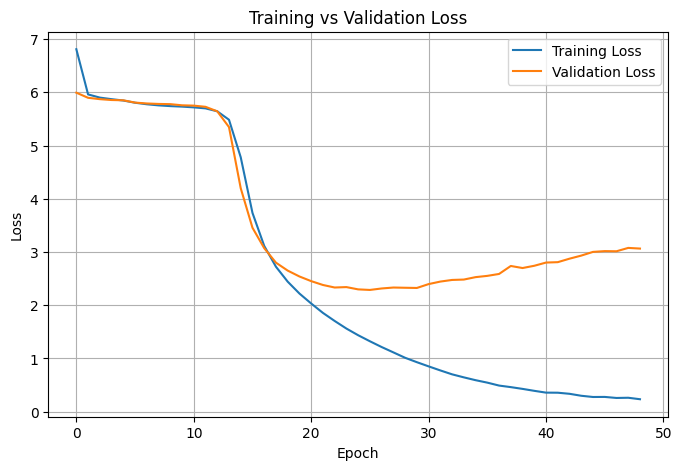

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Test

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

I test the model on the test data by using the Word Error Rate-WER metric.

It measures how different the predicted transcription is from the reference (ground truth).  

WER is based on the Levenshtein distance at the word level, i.e. the minimum number of substitutions (S), deletions (D), and insertions (I) required to transform the predicted sequence into the reference sequence.  

The formula is:  

$$
\text{WER} = \frac{S + D + I}{N}
$$  

where:  
- \(S\) = number of substitutions  
- \(D\) = number of deletions  
- \(I\) = number of insertions  
- \(N\) = total number of words in the reference  



In [ ]:
all_refs,all_hyps = test_wer(
    model,
    test_loader,
    decode_fn=decode_ctc,
    sp=sp,
    normalize_text_fn=normalize_text
)

score = wer(all_refs, all_hyps)  # 0.0 = perfetto, 1.0 = 100% errori
print(f"Test WER: {score:.3f} on {len(all_refs)} sample")

print("Sample ref:", all_refs)
print("Sample hyp:", all_hyps)


Test WER: 0.633 on 1591 utterances
Sample ref: ['da allora la busta nera è diventata una costante del programma', 'l anno precedente era morto il padre', 'è infiammabile e nocivo per inalazione e contatto con la pelle', 'sui lati sono ancora visibili i muri precedenti', 'è dicembre', 'velasco divenne presto il principale punto di riferimento della sua carriera anche in nazionale', 'stein aveva con sé un paio di dischi che lanciò al cane', 'epigoni di detta linea mantengono il cognome colonna romano in palermo e roma', 'finirà ucciso da una delle quattro donne precipitando dal balcone di casa sua', 'è conosciuto a livello internazionale per le sue sculture pubbliche monumentali', 'questi alberi chiudendo il piano anteriormente e posteriormente aumentano il volume di carico', 'il termine italianizzato non ufficiale croce di città è stato introdotto in epoca fascista', 'le iniziative provenivano spesso dalle stesse famiglie patrizie prima fra tutte quella dei cornaro', 'è severamente viet

In [ ]:
for idx, ref in enumerate(all_refs):
    print(all_refs[idx])
    print(all_hyps[idx])

    # Filtra la riga del dataframe che ha quella sentence
    df['sentence'] = df['sentence'].apply(normalize_text)
    mask = df['sentence'] == ref
    path = df.loc[mask, 'path'].values[0]  # Prende il primo match

    audio, sr = get_info_audio(path)
    display(Audio(audio, rate=sr))
